 ## Contents:
1. [Data Visualization](#first-section)
2. [Data Processing:](#second-section)
    1. [Train Set](#second-section)
    2. [Test Set](#third-section)
3. [Linear Regression:](#fourth_section)
    1. [MLR](#fifth_section)
    2. [Ridge](#sixth_section)
        1. [Submission #1](#seventh_section)
    3. [Elastic-Net](#eighth_section)
4. [Tree-Based Models](#ninth-section)
    1. [Simple Decision Tree](#tenth-section)
    2. [Random Forest](#eleventh-section)
        1. [Submission #2](#twelfth-section)
    3. [Gradient Boosting](#thirteenth-section)
        1. [Submission #3](#fourteenth-section)
    4. [XGBoost](#fifteenth-section)
        1. [Submission #4](#sixteenth-section)
5. [Model Ensembling](#seventeenth-section)

# House Prices: Advanced Regression Techniques

In [248]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('data/train.csv')
train = train.drop('Id', axis = 1)
test = pd.read_csv('data/test.csv')

# Data Visualization: <a class="anchor" id="first-section"></a>
### What does the data look like?

In [249]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0, 0.5, 'Count')

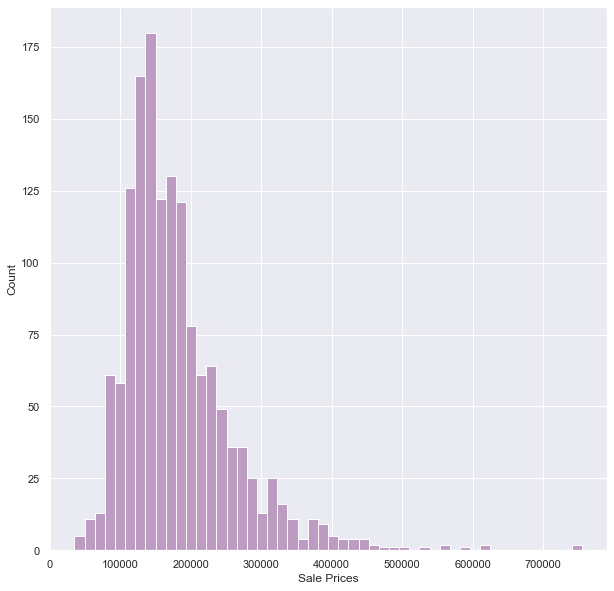

In [250]:
sns.set(rc={'figure.figsize':(10,10)})
plt.hist(train.SalePrice, bins = 50, color = "#BD9BC2")
plt.xlabel('Sale Prices')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

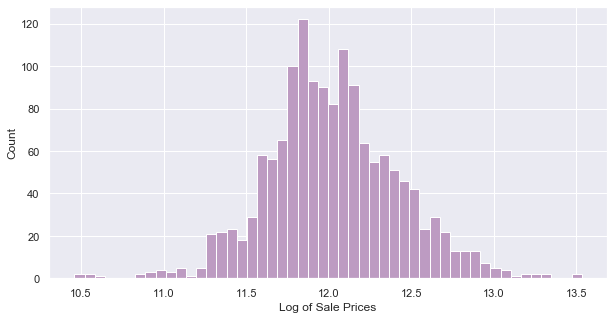

In [251]:
sns.set(rc={'figure.figsize':(10,5)})
plt.hist(np.log(train.SalePrice), bins = 50, color = "#BD9BC2")
plt.xlabel('Log of Sale Prices')
plt.ylabel('Count')

In [ ]:
# right skew to the target variable, but taking the log corrects corrects much of the issue

Text(0, 0.5, 'Count')

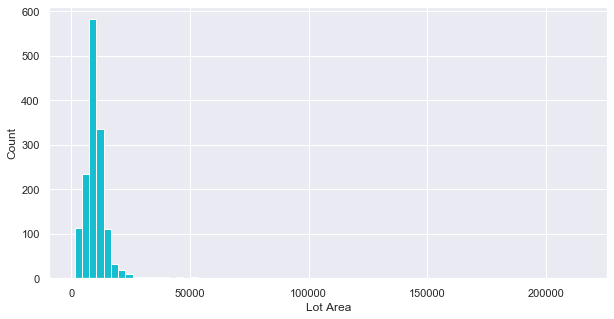

In [252]:
sns.set(rc={'figure.figsize':(10,5)})
plt.hist(train.LotArea, bins = 70, color = 'tab:cyan')
plt.xlabel('Lot Area')
plt.ylabel('Count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207747A7AC8>,
      dtype=object)

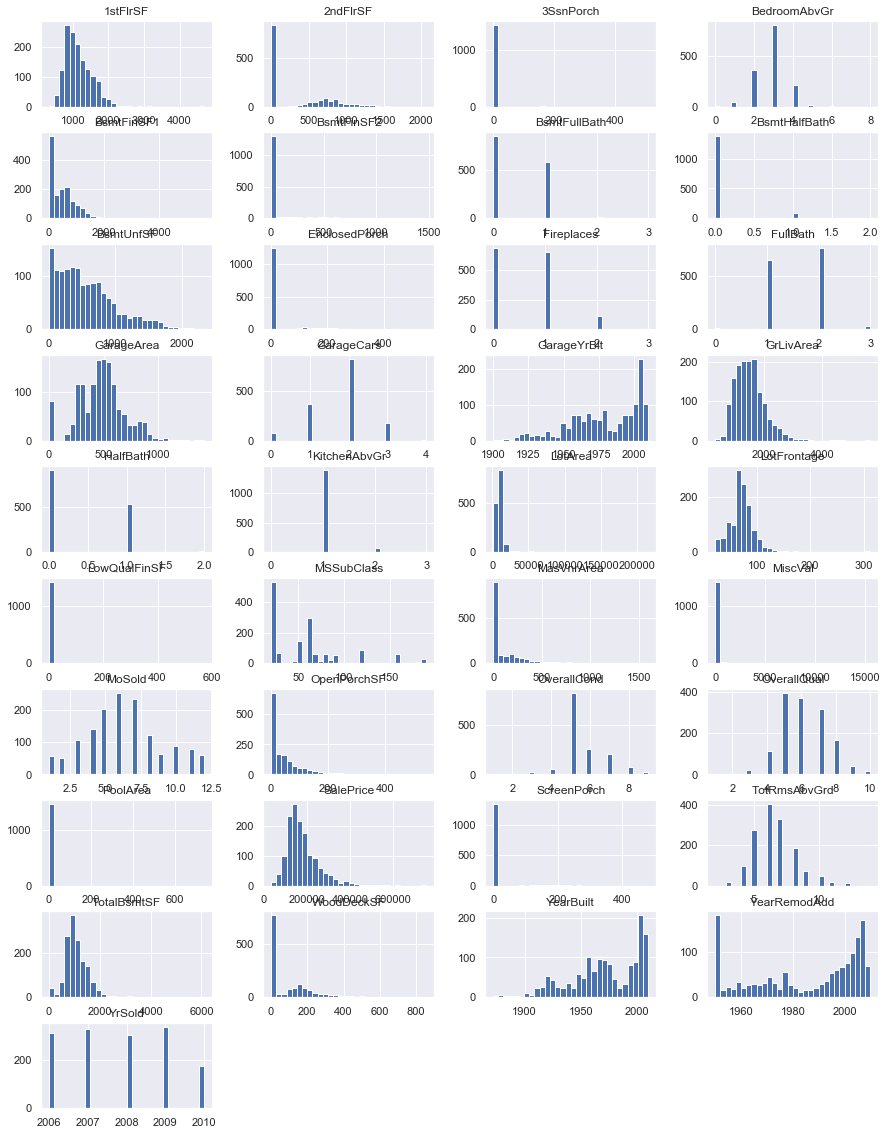

In [253]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.hist(layout = (10,4), bins = 30, figsize=(15,20))

In [7]:
skewed = ['1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GrLivArea', 'TotalBsmtSF', 'OpenPorchSF']

### Explore the relationship between sale price and other variables:

The top 5 positively & negatively correlated features:

In [200]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
corr[['SalePrice']].sort_values('SalePrice', ascending=False)[:10].style.background_gradient(cmap='RdBu_r')

,SalePrice
SalePrice,1
OverallQual,0.800858
GrLivArea,0.699958
GarageCars,0.649256
GarageArea,0.636964
1stFlrSF,0.597753
FullBath,0.559048
TotRmsAbvGrd,0.537462
YearBuilt,0.535279
YearRemodAdd,0.521428


In [9]:
corr[['SalePrice']].sort_values('SalePrice', ascending=True)[:10].style.background_gradient(cmap='RdBu')

,SalePrice
KitchenAbvGr,-0.135907
EnclosedPorch,-0.128578
MSSubClass,-0.0842841
OverallCond,-0.0778559
YrSold,-0.0289226
LowQualFinSF,-0.0256061
MiscVal,-0.0211896
BsmtHalfBath,-0.0168442
BsmtFinSF2,-0.0113781
3SsnPorch,0.0445837


In [254]:
high_corr = corr[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']]
high_corr = high_corr[high_corr.index.isin(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])]
high_corr.sort_values('SalePrice', ascending=False).style.background_gradient(cmap='RdBu_r')

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
SalePrice,1,0.800858,0.699958,0.649256,0.636964,0.32984
OverallQual,0.800858,1,0.60376,0.598739,0.554905,0.339849
GrLivArea,0.699958,0.60376,1,0.493901,0.464328,0.198931
GarageCars,0.649256,0.598739,0.493901,1,0.886882,0.208156
GarageArea,0.636964,0.554905,0.464328,0.886882,1,0.222174
TotalBsmtSF,0.32984,0.339849,0.198931,0.208156,0.222174,1


Inspecting the relationships further:

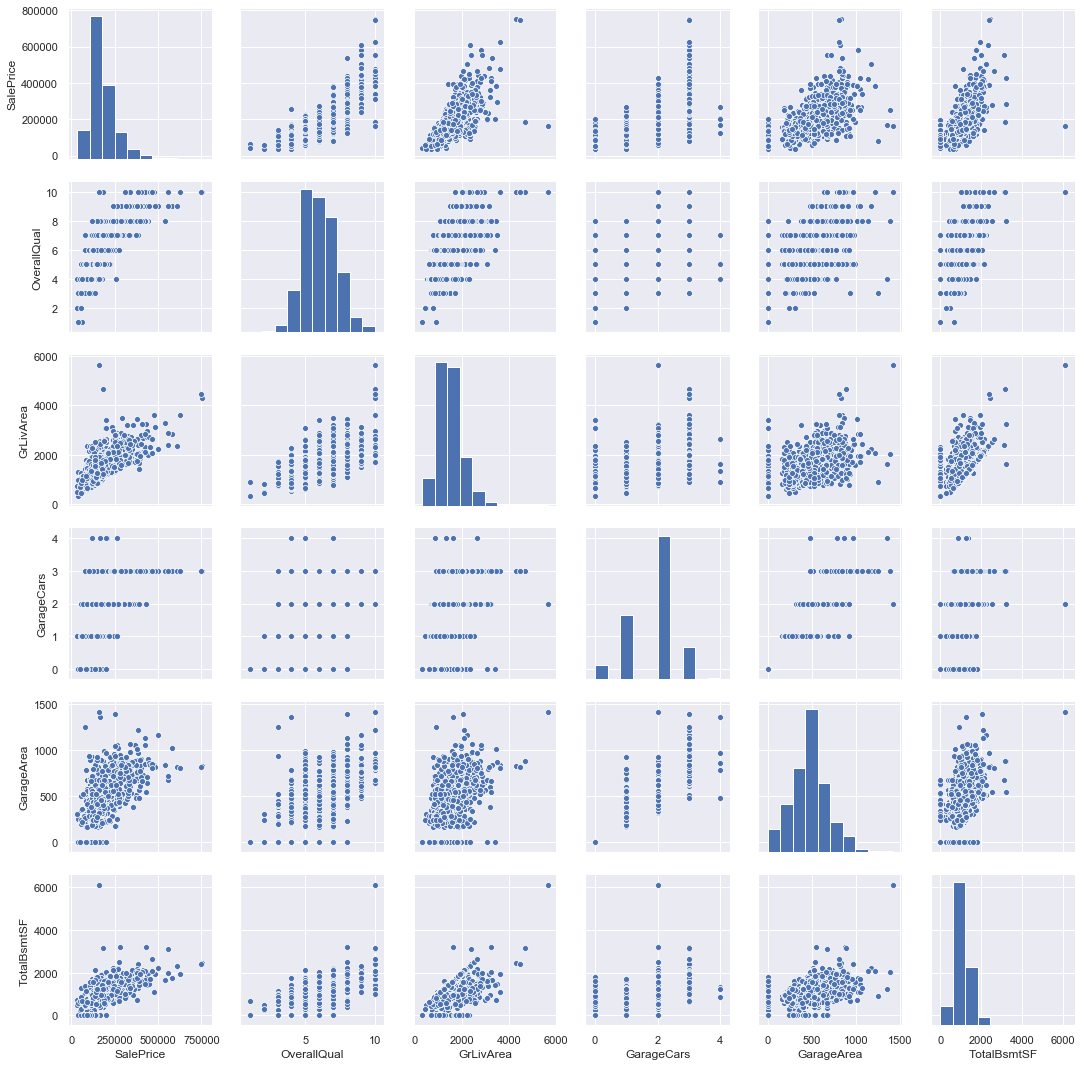

In [255]:

# top positively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']]) 
            #y_vars=['SalePrice'],
            #x_vars=['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'])

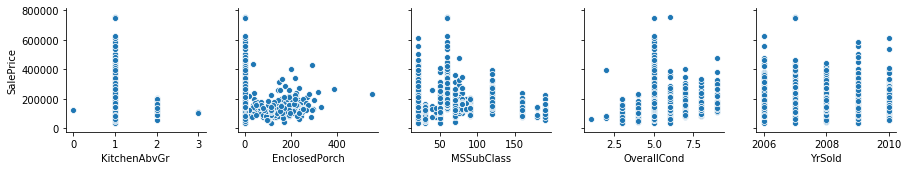

In [12]:
# top negatively correlated variables
sns.pairplot(numeric_features[['SalePrice', 'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold']],
            y_vars= ['SalePrice'], 
            x_vars = ['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold'])

### Categorical Features

In [13]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


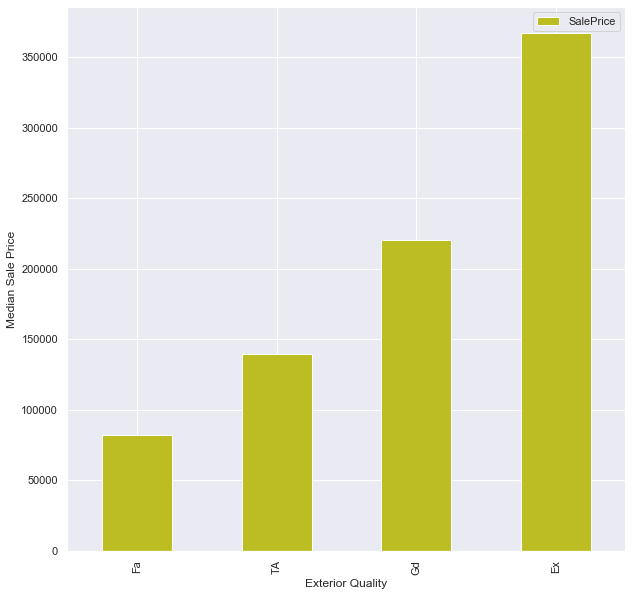

In [201]:
sns.set(rc={'figure.figsize':(10,10)})
pivot = train.pivot_table(index='ExterQual', values='SalePrice', aggfunc=np.median)
pivot = pivot.sort_values('SalePrice')
pivot.plot(kind='bar', color='tab:olive')
plt.xlabel('Exterior Quality')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

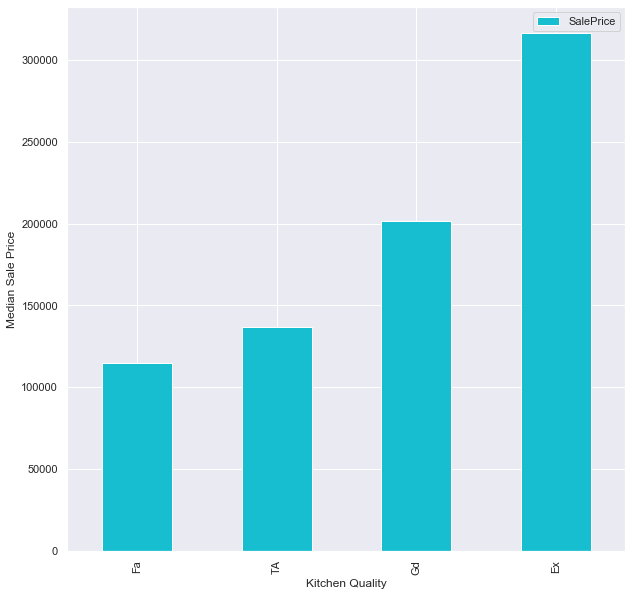

In [202]:
sns.set(rc={'figure.figsize':(10,10)})
pivot = train.pivot_table(index='KitchenQual', values='SalePrice', aggfunc=np.median)
pivot = pivot.sort_values('SalePrice')
pivot.plot(kind='bar', color='tab:cyan')
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
#plt.xticks(rotation=0)
plt.show()

In [16]:
low_variance = ['Street', 'Utilities', 'Heating', 'PoolArea','3SsnPorch', 'PoolQC', 'MiscFeature', 'RoofMatl', 'MiscVal',
               'BsmtHalfBath', 'Alley', 'Electrical', 'Fence', 'KitchenAbvGr', 'LowQualFinSF', 'Condition2']

# Data Processing <a class="anchor" id="second-section"></a>
Handle outliers, missingness and categorical variables

### Outliers

Text(0, 0.5, 'Sale Price')

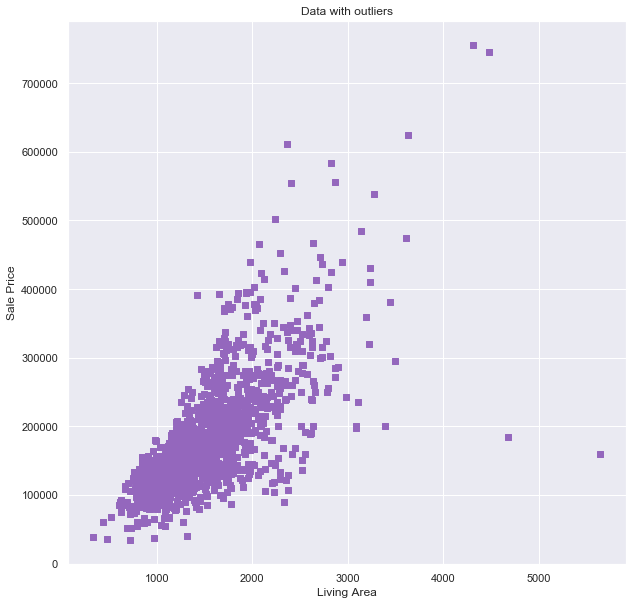

In [257]:
sns.set(rc={'figure.figsize':(10,10)})
plt.scatter(train.GrLivArea, train.SalePrice, color='tab:purple', marker='s')
plt.title('Data with outliers')
plt.xlabel('Living Area')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

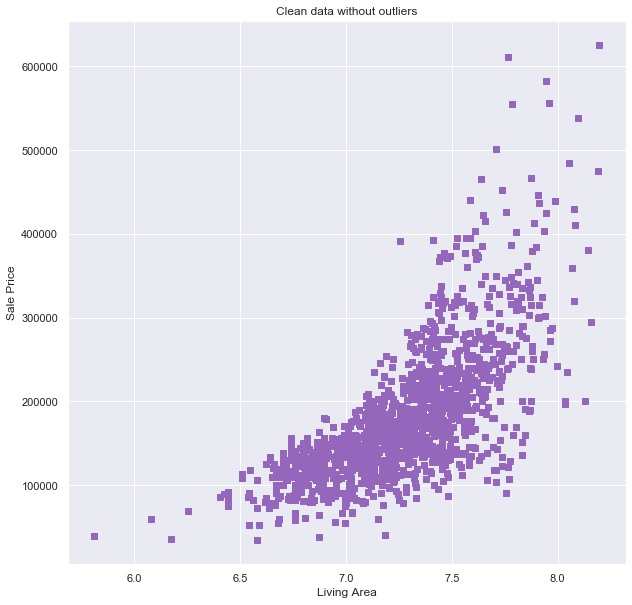

In [215]:
sns.set(rc={'figure.figsize':(10,10)})
train = train[(train.GrLivArea<4000) & (train.SalePrice<700000)]
plt.scatter(train.GrLivArea, train.SalePrice, color='tab:purple', marker='s')
plt.title('Clean data without outliers')
plt.xlabel('Living Area')
plt.ylabel('Sale Price')

In [19]:
from numpy import isneginf

train = train.drop(low_variance, axis=1)

for v in skewed:
    mask = np.log(train[v])
    mask[isneginf(mask)]=0
    train[v] = mask

C:\Users\bdbot\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


### Missingness

In [20]:
missingCols = train.isnull().any(axis=0)
nulls = pd.DataFrame(train[train.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageQual,81
GarageFinish,81
GarageYrBlt,81
GarageType,81
BsmtFinType2,38
BsmtExposure,38


In [21]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.columns[numeric_features.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [22]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='distance')
numeric_features = pd.DataFrame(data=imputer.fit_transform(numeric_features), columns=numeric_features.columns, index=numeric_features.index)


In [23]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('No Fireplace')
train['GarageCond'] = train['GarageCond'].fillna('No Garage')
train['GarageQual'] = train['GarageQual'].fillna('No Garage')
train['GarageFinish'] = train['GarageFinish'].fillna('No Garage')
train['GarageType'] = train['GarageType'].fillna('No Garage')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('No Basement')
train['BsmtExposure'] = train['BsmtExposure'].fillna('No Basement')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('No Basement')
train['BsmtCond'] = train['BsmtCond'].fillna('No Basement')
train['BsmtQual'] = train['BsmtQual'].fillna('No Basement')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
categoricals = train.select_dtypes(exclude=[np.number])

### Dummify Categorical Variables

In [24]:
# Features for LR use only:
dummified_features = pd.concat([numeric_features, categoricals], axis = 1)
dummified_features = dummified_features[train.columns].drop('SalePrice', axis =1)

# Binary Categorical Variables can be changed to 0 or 1:
dummified_features['CentralAir'] = dummified_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_features['MSSubClass'] = dummified_features['MSSubClass'].astype(str)

In [26]:
dummy_cats = dummified_features.select_dtypes(exclude=[np.number])
dummy_cats.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [27]:
print(dummified_features.shape)
for variable in dummy_cats.columns:
    dummy = pd.get_dummies(dummified_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_features[variable][1]]), axis=1, inplace=True) # 
    dummified_features = dummified_features.drop(variable, axis=1)  # drop the original feature
    dummified_features = pd.concat([dummified_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_features.shape)

(1456, 63)
(1456, 228)


In [28]:
print(dummified_features.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Partial'],
      dtype='object', length=228)


### Encode Categorical Variables

Tree-Based models work easily with encoded categorical variables because the distance between integers does not impact how the model is built. Here we will encode the categorical variables instead of dummifying them.

In [29]:
# Features for TBM use only:
encoded_features = pd.concat([numeric_features, categoricals], axis = 1)
encoded_features = encoded_features[train.columns].drop('SalePrice', axis =1)
# Binary Categorical Variables can be changed to 0 or 1:
encoded_features['CentralAir'] = encoded_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Since we are encoding the categorical variables 
# for tree-based models, we can keep this variable as is.
# dummified_features['MSSubClass'] = dummified_features['MSSubClass'].astype(str)

In [31]:
encoded_cats = encoded_features.select_dtypes(exclude=[np.number])
encoded_cats.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [32]:
lencoder = LabelEncoder()
print(encoded_features.shape)
for variable in encoded_cats.columns:
    encoded_features[variable] = lencoder.fit_transform(encoded_features[variable]).reshape((-1,1))
print(encoded_features.shape)

(1456, 63)
(1456, 63)


In [33]:
encoded_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition
0,60.0,3,65.0,8450.0,3,3,4,0,5,2,...,5,2,0.0,4.110874,0.0,0.0,2.0,2008.0,8,4
1,20.0,3,80.0,9600.0,3,3,2,0,24,1,...,5,2,298.0,0.000000,0.0,0.0,5.0,2007.0,8,4
2,60.0,3,68.0,11250.0,0,3,4,0,5,2,...,5,2,0.0,3.737670,0.0,0.0,9.0,2008.0,8,4
3,70.0,3,60.0,9550.0,0,3,0,0,6,2,...,5,2,0.0,3.555348,272.0,0.0,2.0,2006.0,8,0
4,60.0,3,84.0,14260.0,0,3,2,0,15,2,...,5,2,192.0,4.430817,0.0,0.0,12.0,2008.0,8,4


# Process Test Data: <a class="anchor" id="third-section"></a>

In [34]:
test = test.drop(low_variance, axis=1)

for v in skewed:
    mask = np.log(test[v])
    mask[isneginf(mask)]=0
    test[v] = mask

C:\Users\bdbot\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


### Missingness

In [35]:
missingCols = test.isnull().any(axis=0)
nulls = pd.DataFrame(test[test.columns[missingCols]].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
FireplaceQu,730
LotFrontage,227
GarageQual,78
GarageFinish,78
GarageYrBlt,78
GarageCond,78
GarageType,76
BsmtCond,45
BsmtExposure,44


In [36]:
numeric_test = test.select_dtypes(include=[np.number])
numeric_test.columns[numeric_test.isnull().any(axis=0)]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

In [37]:
imputer = KNNImputer(n_neighbors=2, weights='distance')
numeric_test = pd.DataFrame(data=imputer.fit_transform(numeric_test), 
                                columns=numeric_test.columns, index=numeric_test.index)
numeric_test.shape

(1459, 31)

In [38]:
test['FireplaceQu'] = test['FireplaceQu'].fillna('No Fireplace')
test['GarageFinish'] = test['GarageFinish'].fillna('No Garage')
test['GarageType'] = test['GarageType'].fillna('No Garage')
test['BsmtExposure'] = test['BsmtExposure'].fillna('No Basement')
test['BsmtFinType2'] = test['BsmtFinType2'].fillna('No Basement')
test['BsmtFinType1'] = test['BsmtFinType1'].fillna('No Basement')
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['Functional'] = test['Functional'].fillna(test['Functional'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])

test['GarageCond'] = test['GarageCond'].fillna('No Garage')
test['GarageQual'] = test['GarageQual'].fillna('No Garage')
test['BsmtCond'] = test['BsmtCond'].fillna('No Basement')
test['BsmtQual'] = test['BsmtQual'].fillna('No Basement')
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

test_categoricals = test.select_dtypes(exclude=[np.number])
test_categoricals.shape

(1459, 33)

### Dummify Categorical Variables

In [39]:
dummified_test_features = pd.concat([numeric_test, test_categoricals], axis = 1)
dummified_test_features = dummified_test_features[test.columns].drop('Id', axis =1)
# Binary Categorical Variables can be changed to 0 or 1:
dummified_test_features['CentralAir'] = dummified_test_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

# MSSubClass refers to categories, but is currently an integer type. Changing to string type, since the distance 
# between categories doesn't mean anything.
dummified_test_features['MSSubClass'] = dummified_test_features['MSSubClass'].astype(str)

In [40]:
dummytest_categoricals = dummified_test_features.select_dtypes(exclude=[np.number])
dummytest_categoricals.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [41]:
print(dummified_test_features.shape)
for variable in dummytest_categoricals:
    dummy = pd.get_dummies(dummified_test_features[variable], prefix=variable)
    dummy.drop('_'.join([variable, dummified_test_features[variable][1]]), axis=1, inplace=True) # 
    dummified_test_features = dummified_test_features.drop(variable, axis=1)  # drop the original feature
    dummified_test_features = pd.concat([dummified_test_features, dummy], axis=1) # concat original df and dummy horizontally
print(dummified_test_features.shape)

(1459, 63)
(1459, 224)


In [42]:
# 224 columns instead of 228. Need to make these match:
missing_cols = set(dummified_features.columns) - set(dummified_test_features.columns)
for c in missing_cols:
    dummified_test_features[c] = 0
dummified_test_features = dummified_test_features[dummified_features.columns]
print(dummified_test_features.shape)
print(dummified_features.shape)

(1459, 228)
(1456, 228)


### Encode Categorical Variables

In [43]:
encoded_test_features = pd.concat([numeric_test, test_categoricals], axis = 1)
encoded_test_features = encoded_test_features[test.columns].drop('Id', axis =1)
# Binary Categorical Variables can be changed to 0 or 1:
encoded_test_features['CentralAir'] = encoded_test_features['CentralAir'].apply(lambda x: 0 if x == 'N' else 1)

In [44]:
encodedtest_categoricals = encoded_test_features.select_dtypes(exclude=[np.number])
encodedtest_categoricals.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [45]:
lencoder = LabelEncoder()
print(encoded_test_features.shape)
for variable in encodedtest_categoricals.columns:
    encoded_test_features[variable] = lencoder.fit_transform(encoded_test_features[variable]).reshape((-1,1))
print(encoded_test_features.shape)

(1459, 63)
(1459, 63)


# Linear Regression Models <a class="anchor" id="fourth_section"></a>

## Mutiple Linear Regression <a class="anchor" id="fifth_section"></a>

In [79]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = np.log(train.SalePrice)
X = dummified_features

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=503, test_size=.30)
#mlr = linear_model.LinearRegression()
#saturated_model = mlr.fit(X_train, y_train)

In [47]:
print ("Error for the training data : ", 1-saturated_model.score(X_train, y_train))
print ("Error for the test data : ", 1-saturated_model.score(X_test, y_test))

Error for the training data :  0.04884806658542329
Error for the test data :  0.09728049182616039


In [48]:
train_predictions = saturated_model.predict(X_train)
test_predictions = saturated_model.predict(X_test)

# log is already taken on predicted values and actual values, and we'll keep it that way as Kaggle's evaluation method takes 
# the log to reduce the impact of very high house prices
print ('Train RMSE :', np.sqrt(mean_squared_error(y_train, train_predictions)))
print ('Test RMSE :', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train RMSE : 0.0882854928403823
Test RMSE : 0.1208983275575182


In [49]:
import statsmodels.api as sm
X_Constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_Constant)
results = model.fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     70.22
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        17:09:47   Log-Likelihood:                 1027.4
No. Observations:                1019   AIC:                            -1611.
Df Residuals:                     797   BIC:                            -517.1
Df Model:                         221                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

C:\Users\bdbot\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Check assumptions of MLR:

Linearity:

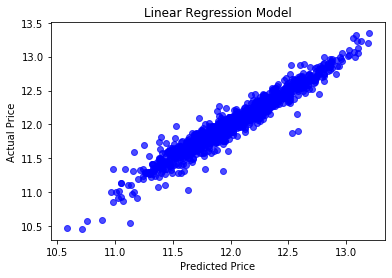

In [50]:
plt.scatter(saturated_model.predict(X), y, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

Normally distributed errors:

(array([  2.,   1.,   2.,   0.,   0.,   0.,   2.,   0.,   1.,   2.,   5.,
          7.,  16.,  33.,  41., 107., 193., 286., 297., 193., 131.,  75.,
         31.,  10.,   7.,   4.,   1.,   5.,   1.,   3.]),
 array([-6.82179915e-01, -6.44273249e-01, -6.06366582e-01, -5.68459915e-01,
        -5.30553249e-01, -4.92646582e-01, -4.54739915e-01, -4.16833249e-01,
        -3.78926582e-01, -3.41019915e-01, -3.03113249e-01, -2.65206582e-01,
        -2.27299915e-01, -1.89393249e-01, -1.51486582e-01, -1.13579915e-01,
        -7.56732488e-02, -3.77665821e-02,  1.40084561e-04,  3.80467512e-02,
         7.59534179e-02,  1.13860085e-01,  1.51766751e-01,  1.89673418e-01,
         2.27580085e-01,  2.65486751e-01,  3.03393418e-01,  3.41300085e-01,
         3.79206751e-01,  4.17113418e-01,  4.55020085e-01]),
 <a list of 30 Patch objects>)

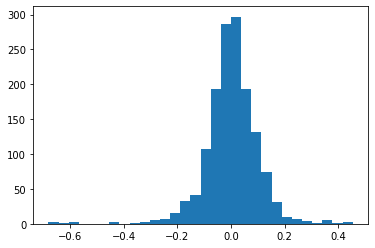

In [51]:
residuals = y - saturated_model.predict(X)
plt.hist(residuals, bins = 30)

Constant variance and independent Errors:

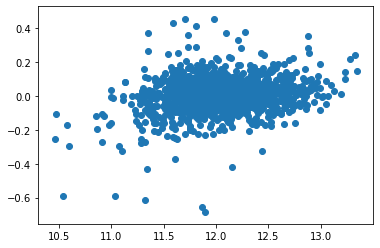

In [52]:
plt.scatter(y, residuals)

Multicollinearity:

Using all variables requires using many related variables, such as the numerous variables relating to the basement or the garage. These variables add different but related information. Penalized linear regression will be used to address multicollinearity issues, decrease variance, and increase accuracy. Lasso will have the additional benefit of feature selection.

## Ridge Linear Regression <a class="anchor" id="sixth_section"></a>

In [53]:
from sklearn.linear_model import Lasso, Ridge

ridge = Ridge()

ridge.set_params(alpha = 0, normalize = False)
ridge.fit(X_train, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [54]:
print ("Error for the training data : ", ridge.score(X_train, y_train))
print ("Error for the test data : ", ridge.score(X_test, y_test))

Error for the training data :  -1.8634781233042033
Error for the test data :  -3.52144659423495


In [57]:
train_predictions = ridge.predict(X_train)
test_predictions = ridge.predict(X_test)

print ('Train RMSE :', np.sqrt(mean_squared_error(y_train, train_predictions)))
print ('Test RMSE :', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train RMSE : 0.6759469161441266
Test RMSE : 0.8242256335585921


In [58]:
coefs = []
intercepts = []
R2_train  = []
R2_test  = []
alphaRange = np.linspace(1e-3, 6,20)
for alpha in alphaRange:
        ridge.set_params(alpha=alpha, normalize=True)  
        ridge.fit(X_train, y_train)
        intercepts.append(ridge.intercept_)
        coefs.append(ridge.coef_)
        R2_train.append(ridge.score(X_train, y_train))
        R2_test.append(ridge.score(X_test, y_test))

Text(0.5, 1.0, 'Change of Ridge Slopes Varying Alpha')

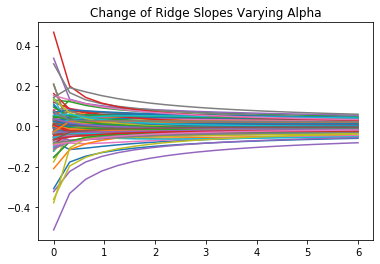

In [59]:
coefs = pd.DataFrame(np.array(coefs), columns=X.columns)

for name in coefs.columns:
    plt.plot(alphaRange, coefs[name], label=name)  
plt.title('Change of Ridge Slopes Varying Alpha')

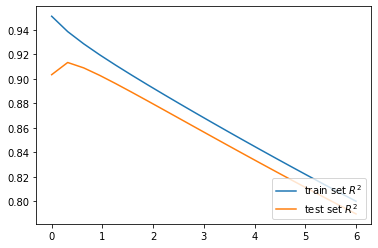

In [60]:
plt.plot(alphaRange, R2_train, label=r'train set $R^2$')
plt.plot(alphaRange, R2_test, label=r'test set $R^2$')
plt.legend(loc=4)

In [62]:
ridge.set_params(alpha=0.4, normalize=False)
ridge_best_alpha = ridge.fit(X_train, y_train)
print(ridge_best_alpha.score(X_train, y_train))
print(ridge_best_alpha.score(X_test, y_test))

0.935815598379333
0.9125187217675584


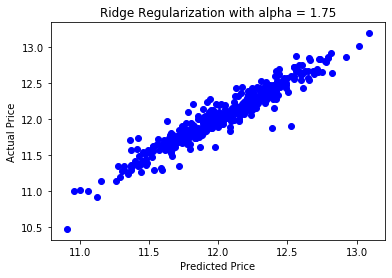

In [63]:
predictions = ridge_best_alpha.predict(X_test)
plt.scatter(predictions, y_test, alpha=1, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = {}'.format(1.75))
plt.show()

In [64]:
print ('RMSE :', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE : 0.11464760173789265


### Predicting Test Set / Submission to Kaggle: <a class="anchor" id="seventh_section"></a>

In [65]:
predictions = np.exp(ridge_best_alpha.predict(dummified_test_features))
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = predictions
submission.to_csv('submission1.csv', index=False)

In [ ]:
# Scored: 0.15293

## Elastic-Net <a class="anchor" id="eighth_section"></a>

In [235]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(normalize=False)
elasticnet.fit(E_X_train, E_y_train)
elasticnet.score(E_X_train, E_y_train)

0.8563028130081846

In [236]:
grid_para_el = [{
    "alpha" : np.logspace(-10, 2, 100),
    "l1_ratio": np.linspace(0.1,1, 10),
}]
grid_search_el = GridSearchCV(elasticnet, grid_para_el, cv=5, scoring=log_rmse_scorer, n_jobs=-1)
%time grid_search_el.fit(E_X_train, E_y_train)

Wall time: 10.9 s


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-10, 1.32194115e-10, 1.74752840e-10, 2.31012970e-1...
       4.64158883e+00, 6.13590727e+00, 8.11130831e+00, 1.07226722e+01,
       1.41747416e+01, 1.87381742e+01, 2.47707636e+01, 3.27454916e+01,
       4.32876128e+01, 5.72236766e+01, 7.56463328e+01, 1.00000000e+02]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(log_rmse, greater_is_better=

In [238]:
grid_search_el.best_params_, -grid_search_el.best_score_

({'alpha': 1.5199110829529332, 'l1_ratio': 0.5}, 0.1776256191349889)

In [240]:
print ("Error for the training data : ", -grid_search_el.score(E_X_train, E_y_train))
print ("Error for the test data : ", -grid_search_el.score(E_X_test, E_y_test))

Error for the training data :  0.16657624344752292
Error for the test data :  0.15166360467037202


In [241]:
train_predictions = grid_search_el.predict(E_X_train)
test_predictions = grid_search_el.predict(E_X_test)

print ('Train RMSE :', np.sqrt(mean_squared_error(np.log(E_y_train), np.log(train_predictions))))
print ('Test RMSE :', np.sqrt(mean_squared_error(np.log(E_y_test), np.log(test_predictions))))

Train RMSE : 0.16657624344752292
Test RMSE : 0.15166360467037202


# Tree Based Models <a class="anchor" id="ninth-section"></a>

In [66]:
# Custom scorer for gridsearch - based on the evaluation criteria of the kaggle competition.

from sklearn.metrics import make_scorer

def log_rmse(actual, predict):
    predict = np.array(np.log(predict))
    actual = np.array(np.log(actual))

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

log_rmse_scorer = make_scorer(log_rmse, greater_is_better = False)

# Decision Tree <a class="anchor" id="tenth-section"></a>

In [80]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

tree_model = tree.DecisionTreeRegressor()

E_y = train.SalePrice

E_X_train, E_X_test, E_y_train, E_y_test = train_test_split(encoded_features,E_y, random_state=503, test_size=0.3)

In [81]:
grid_para_tree = [{
    "max_depth" : range(2, 30, 2),
    "min_samples_leaf": range(1, 15, 2),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring=log_rmse_scorer, n_jobs=-1)
%time grid_search_tree.fit(E_X_train, E_y_train)

Wall time: 9.07 s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=108,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'max_depth': range(2, 30, 2),
                          'min_samples_leaf': range(1, 15, 2),
                          'min_samples_

In [82]:
grid_search_tree.best_params_, -grid_search_tree.best_score_

({'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 22},
 0.18704807021191938)

In [83]:
print ("Train RMSE :", -grid_search_tree.score(E_X_train, E_y_train))
print ("Test RMSE :", -grid_search_tree.score(E_X_test, E_y_test))

Train RMSE : 0.12892508289066534
Test RMSE : 0.18880216523460744


Next I compare the scorer to manually computed RMSE, which matches perfectly:

In [84]:
train_predictions = grid_search_tree.predict(E_X_train)
test_predictions = grid_search_tree.predict(E_X_test)

print ('Train RMSE :', np.sqrt(mean_squared_error(np.log(E_y_train), np.log(train_predictions))))
print ('Test RMSE :', np.sqrt(mean_squared_error(np.log(E_y_test), np.log(test_predictions))))

Train RMSE : 0.12892508289066534
Test RMSE : 0.18880216523460744


But this is still pretty poor performance using a single weak learner. Next we'll try to overcome this using ensemble models. 

# Random Forest Model <a class="anchor" id="eleventh-section"></a>

In [86]:
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()
randomForest.fit(E_X_train, E_y_train) 

#MSE here instead of RMSE
print("The training error is: ", 1-randomForest.score(E_X_train, E_y_train))
print("The test     error is: ", 1-randomForest.score(E_X_test, E_y_test))

The training error is:  0.015708058067631092
The test     error is:  0.14549181110842468


In [87]:
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### **Tune Tree Parameters**

In [88]:
randomForest.set_params(n_estimators= 100)
grid_para_forest1 = {
    'max_depth': range(2, 30, 2),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
}
grid_search_forest1 = GridSearchCV(randomForest, grid_para_forest1, scoring=log_rmse_scorer, cv=5, n_jobs=-1)
%time grid_search_forest1.fit(E_X_train, E_y_train)

Wall time: 55.9 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
grid_search_forest1.best_params_, -grid_search_forest1.best_score_

({'max_depth': 20, 'min_samples_split': 4}, 0.14604255806193817)

In [90]:
print("Train RMSE :", -grid_search_forest1.score(E_X_train, E_y_train))
print("Test RMSE :", -grid_search_forest1.score(E_X_test, E_y_test))

Train RMSE : 0.06347868947392009
Test RMSE : 0.14416068164346363


In [91]:
randomForest.set_params(n_estimators= 100, max_depth=20, min_samples_split=4)
grid_para_forest2 = {
    "min_samples_leaf": range(1, 15, 2),
    "max_features" : range(6,40,2)
}
grid_search_forest2 = GridSearchCV(randomForest, grid_para_forest2, scoring=log_rmse_scorer, cv=5, n_jobs=-1)
%time grid_search_forest2.fit(E_X_train, E_y_train)

Wall time: 15.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=20,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=4,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [92]:
grid_search_forest2.best_params_, -grid_search_forest2.best_score_

({'max_features': 36, 'min_samples_leaf': 1}, 0.1442181560259677)

In [93]:
print("Train RMSE :", -grid_search_forest2.score(E_X_train, E_y_train))
print("Test RMSE :", -grid_search_forest2.score(E_X_test, E_y_test))

Train RMSE : 0.06307833210366792
Test RMSE : 0.13822609879437134


### Increase Number of Trees 

In [94]:
randomForest.set_params(max_depth= 20, max_features= 36, min_samples_leaf= 1, min_samples_split = 4)
grid_para_forest3 = {
    'n_estimators': range(10, 500, 50),
}
grid_search_forest3 = GridSearchCV(randomForest, grid_para_forest3, scoring=log_rmse_scorer, cv=5, n_jobs=-1)
%time grid_search_forest3.fit(E_X_train, E_y_train)

Wall time: 14.5 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=20,
                                             max_features=36,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=4,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,

In [95]:
grid_search_forest3.best_params_, -grid_search_forest3.best_score_

({'n_estimators': 360}, 0.1439515760738681)

In [96]:
print("Train RMSE :", -grid_search_forest3.score(E_X_train, E_y_train))
print("Test RMSE :", -grid_search_forest3.score(E_X_test, E_y_test))

Train RMSE : 0.06272452544302771
Test RMSE : 0.13600966739145404


### Feature Importance

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Score')]

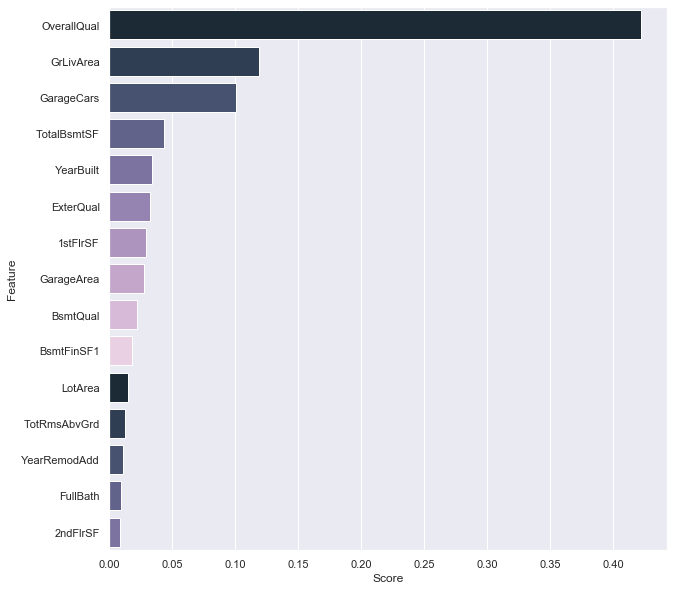

In [114]:
tuned_forest = grid_search_forest3.best_estimator_

feat_importances = pd.DataFrame({'score': tuned_forest.feature_importances_, 'name':encoded_features.columns})

sns.set(rc={'figure.figsize':(10,10)})
fi = sns.barplot(y='name', x='score', data =(feat_importances.nlargest(15, 'score')), 
            palette=sns.cubehelix_palette(10,start=2.5, reverse=True))
fi.set(xlabel='Score', ylabel='Feature')

### Predicting Test Set / Submission to Kaggle: <a class="anchor" id="twelfth-section"></a>

In [98]:
predictions = tuned_forest.predict(encoded_test_features)
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = predictions
submission.to_csv('submission2.csv', index=False)

In [ ]:
#Scored: 0.14771

A random forest model improved the predictive accuracy substantially over the single decision tree. Using the feature importance tool, we can see that Overall Quality had the biggest influence on predicted house prices, followed by 'ground living area.' In order to improve performance further, I'll be moving to a gradient boosting model.

# Gradient Boosting <a class="anchor" id="thirteenth-section"></a>

In [102]:
from sklearn.ensemble import GradientBoostingRegressor
gbmr = GradientBoostingRegressor()

gbmr.fit(E_X_train, E_y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
gbmr.score(E_X_train, E_y_train), gbmr.score(E_X_test, E_y_test)

(0.9708216469079451, 0.8878757203742965)

### Learning Rate 

In [107]:
from sklearn.metrics import r2_score 
n_estimators = 50100
steps = range(100, 50100, 1000)

gbmr.set_params(learning_rate = 1, n_estimators=n_estimators, max_depth=3)
gbmr.fit(E_X_train, E_y_train)
gen = gbmr.staged_predict(E_X_train)
score1 = []
for n in range(n_estimators):
    predicted_targets = next(gen)
    if n not in steps: continue
    score1.append(np.sqrt(mean_squared_error(np.log(E_y_train), np.log(predicted_targets))))

In [108]:
gbmr.set_params(learning_rate = 0.1)
gbmr.fit(E_X_train, E_y_train)
gen = gbmr.staged_predict(E_X_train)
score01 = []
for n in range(n_estimators):
    predicted_targets = next(gen)
    if n not in steps: continue
    score01.append(np.sqrt(mean_squared_error(np.log(E_y_train), np.log(predicted_targets))))

In [109]:
gbmr.set_params(learning_rate = 0.01)
gbmr.fit(E_X_train, E_y_train)
gen = gbmr.staged_predict(E_X_train)
score001 = []
for n in range(n_estimators):
    predicted_targets = next(gen)
    if n not in steps: continue
    score001.append(np.sqrt(mean_squared_error(np.log(E_y_train), np.log(predicted_targets))))

Text(0.5, 0, 'Number of Trees')

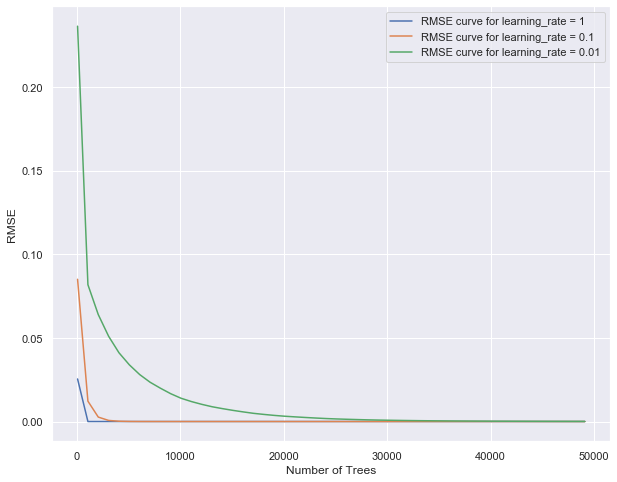

In [113]:
sns.set(rc={'figure.figsize':(10,8)})
plt.plot(steps, score1,  label=r'RMSE curve for learning_rate = 1')
plt.plot(steps, score01, label=r'RMSE curve for learning_rate = 0.1')
plt.plot(steps, score001, label=r'RMSE curve for learning_rate = 0.01')
plt.legend(loc=1)
plt.ylabel('RMSE')
plt.xlabel('Number of Trees')

We can see from the above that the model converges very quickly with a learning rate greater than 0.01. 

### Parameter Tuning

First, I will set the learning rate high while I tune the tree-based parameters, then I'll drop the learning rate and increase the number of trees to find the optimal performance.

In [115]:
gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate = 0.1, min_samples_split = 30, min_samples_leaf = 15, max_depth = 5, 
                max_features = 25, subsample = 0.8)
param_test1 = {'n_estimators':range(20,810,10)}
gsearch1 = GridSearchCV(gbmr, param_grid = param_test1, scoring=log_rmse_scorer, n_jobs=-1, iid=False, cv=5)
gsearch1.fit(E_X_train, E_y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=5,
                                                 max_features=25,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=15,
                                                 min_samples_split=30,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [116]:
gsearch1.best_params_, -gsearch1.best_score_

({'n_estimators': 720}, 0.12607788836650768)

In [117]:
print("Train RMSE :", -gsearch1.score(E_X_train, E_y_train))
print("Test RMSE :", -gsearch1.score(E_X_test, E_y_test))

Train RMSE : 0.01165371336701599
Test RMSE : 0.12297294720150727


### Tree-Level Parameters

In [118]:
gbmr.set_params(learning_rate = 0.1, n_estimators = 720, subsample = 0.8)
param_test2 = {'max_depth':range(3,16,2), 
               'min_samples_split':range(4, 40, 2), 
               'min_samples_leaf':range(4,20,2), 
               'max_features':range(4,20,2)}
gsearch2 = GridSearchCV(gbmr, param_grid = param_test2, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
%time gsearch2.fit(E_X_train, E_y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 1h 11min 3s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=5,
                                                 max_features=25,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=15,
                                                 min_samples_split=30,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=720,
                                                 n_iter_n...
                            

In [119]:
gsearch2.best_params_, -gsearch2.best_score_

({'max_depth': 3,
  'max_features': 14,
  'min_samples_leaf': 4,
  'min_samples_split': 30},
 0.12414445102639723)

In [120]:
print("Train RMSE :", -gsearch2.score(E_X_train, E_y_train))
print("Test RMSE :", -gsearch2.score(E_X_test, E_y_test))

Train RMSE : 0.03945637822072576
Test RMSE : 0.11763973209489594


### Subsample Parameter

In [121]:
gbmr.set_params(learning_rate = 0.1, n_estimators = 720, min_samples_leaf = 4, max_features = 14, min_samples_split = 30,  
                max_depth = 3)
param_test3 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch3 = GridSearchCV(gbmr, param_grid = param_test3, scoring=log_rmse_scorer, n_jobs=-1, iid=False, cv=5)
gsearch3.fit(E_X_train, E_y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=14,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=4,
                                                 min_samples_split=30,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=720,
                                                 n_iter_no_change=None,
                  

In [122]:
gsearch3.best_params_, -gsearch3.best_score_

({'subsample': 0.8}, 0.12920193789840442)

In [123]:
print("Train RMSE :", -gsearch3.score(E_X_train, E_y_train))
print("Test RMSE :", -gsearch3.score(E_X_test, E_y_test))

Train RMSE : 0.03864685940189392
Test RMSE : 0.11512483726053656


### Lower Learning-Rate and Increase Number of Trees

In [125]:
gbmr.set_params(learning_rate = 0.01,  n_estimators = 720, min_samples_leaf = 4, max_features = 14, min_samples_split = 30,  
                max_depth = 3, subsample = 0.8)
param_test4 = {'n_estimators':range(100,10000,500)}
gsearch4 = GridSearchCV(gbmr, param_grid = param_test4, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
%time gsearch4.fit(E_X_train, E_y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 53.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.01,
                                                 loss='ls', max_depth=3,
                                                 max_features=14,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=4,
                                                 min_samples_split=30,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=720,
                                                 n_iter_no_change=None,
                 

In [126]:
gsearch4.best_params_, -gsearch4.best_score_

({'n_estimators': 6600}, 0.12265057653813453)

In [127]:
print("Train RMSE :", -gsearch4.score(E_X_train, E_y_train))
print("Test RMSE :", -gsearch4.score(E_X_test, E_y_test))

Train RMSE : 0.03932666722214997
Test RMSE : 0.10981636666169882


### Feature Importance

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Score')]

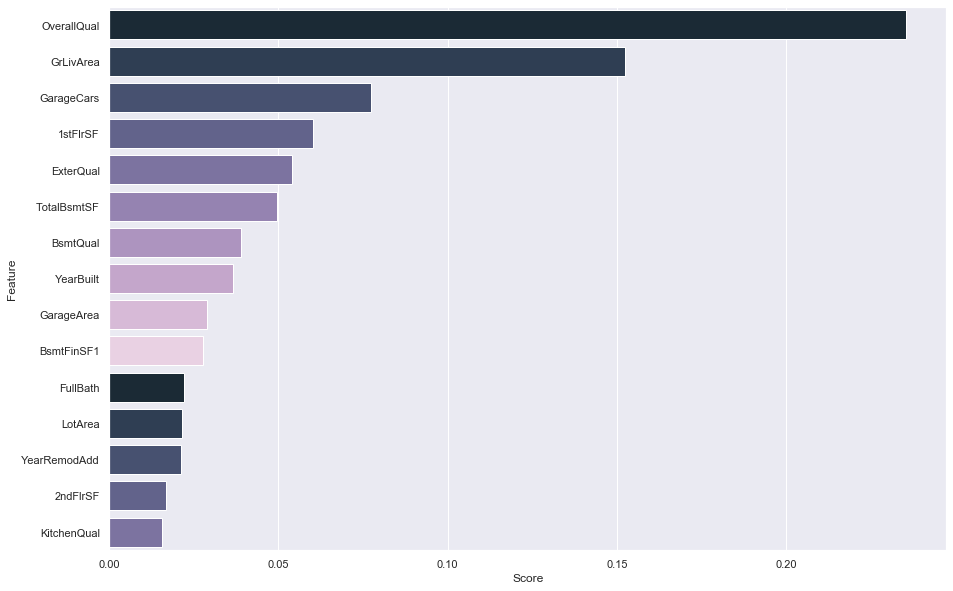

In [129]:
tuned_gbm = gsearch4.best_estimator_

feat_importances = pd.DataFrame({'score': tuned_gbm.feature_importances_, 'name':encoded_features.columns})

sns.set(rc={'figure.figsize':(15, 10)})
fi = sns.barplot(y='name', x='score', data =(feat_importances.nlargest(15, 'score')), 
            palette=sns.cubehelix_palette(10,start=2.5, reverse=True))
fi.set(xlabel='Score', ylabel='Feature')

### Predicting Test Set / Submission to Kaggle: <a class="anchor" id="fourteenth-section"></a>

In [130]:
predictions = gsearch4.predict(encoded_test_features)
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = predictions
submission.to_csv('submission3.csv', index=False)

In [ ]:
# Scored: 0.13088

The gradient boosting model improved predictive accuracy significantly. But can we do better?

## XGBoost Model <a class="anchor" id="fifteenth-section"></a>

Parameter tuning advice:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

How parallelization works in series ensembling:
https://medium.com/blablacar-tech/thinking-before-building-xgboost-parallelization-f1a3f37b6e68

XGBoost Documentation:
https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [131]:
import xgboost
from xgboost.sklearn import XGBRegressor

sk_xgb = XGBRegressor()
xgb = xgboost.XGBRegressor()
xgb.fit(E_X_train, E_y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [132]:
xgb.score(E_X_train, E_y_train), xgb.score(E_X_test, E_y_test)

(0.9999141251921769, 0.8629591488450657)

Similarly to the gradient boosting model, I will incrementally tune parameters here, beginning with a high learning rate. Once all parameters are tuned, I'll drop the learning rate and increase the number of trees for a more robust model.

### Initial Model

In [133]:
sk_xgb.set_params(learning_rate =0.1, n_estimators=1000,
               max_depth = 5, min_child_weight = 0, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

### Max_Depth / Min_Child_Weight:

In [135]:
sk_xgb.set_params(learning_rate =0.1, n_estimators=1000,
               max_depth = 3, min_child_weight = 0, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)
param_test1 = {
    'max_depth':range(2,8),
    'min_child_weight':range(1,7,2),
}
xgb_gsearch1 = GridSearchCV(sk_xgb, param_grid = param_test1, scoring= log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
%time xgb_gsearch1.fit(E_X_train, E_y_train)

C:\Users\bdbot\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 28.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=0,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    subsample=0.8, tree_method=None,
                                    validate_parameters=False, verbosity=None)

In [136]:
xgb_gsearch1.best_params_, -xgb_gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.12780286600906596)

In [137]:
print("The training error is: ", -xgb_gsearch1.score(E_X_train, E_y_train))
print("The test     error is: ", -xgb_gsearch1.score(E_X_test, E_y_test))

The training error is:  0.014743543379501997
The test     error is:  0.12041701939945035


### GAMMA:

In [139]:
sk_xgb.set_params(learning_rate =0.1, n_estimators=1000,
               max_depth = 3, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgb_gsearch2 = GridSearchCV(sk_xgb, param_grid = param_test2, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
xgb_gsearch2.fit(E_X_train, E_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    subsample=0.8, tree_method=None,
            

In [140]:
xgb_gsearch2.best_params_, -xgb_gsearch2.best_score_

({'gamma': 0.0}, 0.12780286600906596)

In [141]:
print("The training error is: ", -xgb_gsearch2.score(E_X_train, E_y_train))
print("The test     error is: ", -xgb_gsearch2.score(E_X_test, E_y_test))

The training error is:  0.014743543379501997
The test     error is:  0.12041701939945035


### Subsample / Colsample_bytree

In [142]:
sk_xgb.set_params(learning_rate =0.1, n_estimators=1000,
               max_depth =3, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)

param_test3 = {
 'subsample':np.linspace(0.6, 1.0, 9),
 'colsample_bytree':np.linspace(0.6, 1.0, 9)
}
xgb_gsearch3 = GridSearchCV(sk_xgb, param_grid = param_test3, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
xgb_gsearch3.fit(E_X_train, E_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    subsample=0.8, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),

In [143]:
xgb_gsearch3.best_params_, -xgb_gsearch3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.12586673466473733)

In [144]:
print("The training error is: ", -xgb_gsearch3.score(E_X_train, E_y_train))
print("The test     error is: ", -xgb_gsearch3.score(E_X_test, E_y_test))

The training error is:  0.016785609754304247
The test     error is:  0.12260432262194668


### Regularization Parameter

In [155]:
sk_xgb.set_params(learning_rate =0.1, n_estimators=1000,
               max_depth =3, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.9, scale_pos_weight = 1)

param_test4 = {
 'reg_lambda': np.linspace(0.1, 2, 20)
}
xgb_gsearch4 = GridSearchCV(sk_xgb, param_grid = param_test4, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
xgb_gsearch4.fit(E_X_train, E_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    reg_lambda=None, scale_pos_weight=1,
                                    subsample=0.8, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid=False, n_jobs=-1,
             param_grid={'reg_lamb

In [156]:
xgb_gsearch4.best_params_, -xgb_gsearch4.best_score_

({'reg_lambda': 0.8999999999999999}, 0.12548194383009942)

In [157]:
print("The training error is: ", -xgb_gsearch4.score(E_X_train, E_y_train))
print("The test     error is: ", -xgb_gsearch4.score(E_X_test, E_y_test))

The training error is:  0.014732981760052383
The test     error is:  0.11587720839617864


### Reduce Learning Rate + Increase Trees

In [159]:
sk_xgb.set_params(learning_rate =0.01, n_estimators=1000, reg_alpha =0.9, 
               max_depth =3, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.9, scale_pos_weight = 1)

param_test5 = {
 'n_estimators':range(100, 10000, 500)
}
xgb_gsearch5 = GridSearchCV(sk_xgb, param_grid = param_test5, scoring=log_rmse_scorer,n_jobs=-1,iid=False, cv=5)
xgb_gsearch5.fit(E_X_train, E_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.9,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_delta_step=None,
                                    max_depth=3, min_child_weight=3,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000,...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=0.9,
                                    reg_lambda=None, scale_pos_weight=1,
                                    subsample=0.8, tree_method=None,
              

In [160]:
xgb_gsearch5.best_params_, -xgb_gsearch5.best_score_

({'n_estimators': 9600}, 0.12346495087382414)

In [161]:
print("The training error is: ", -xgb_gsearch5.score(E_X_train, E_y_train))
print("The test     error is: ", -xgb_gsearch5.score(E_X_test, E_y_test))

The training error is:  0.015148423123987417
The test     error is:  0.11527225999901529


### Feature Importance

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Score')]

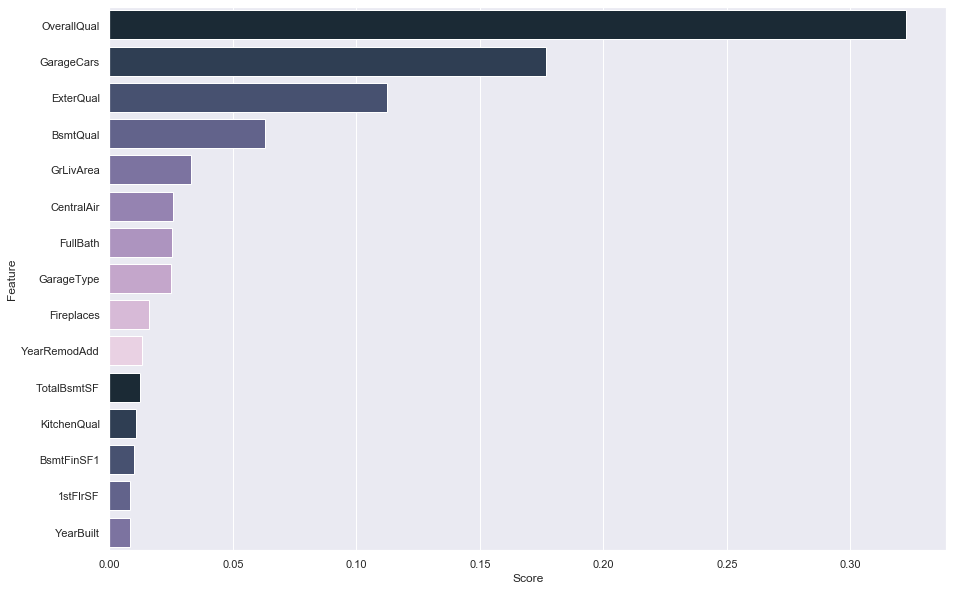

In [164]:
tuned_xgb = xgb_gsearch5.best_estimator_

feat_importances = pd.DataFrame({'score': tuned_xgb.feature_importances_, 'name':encoded_features.columns})

sns.set(rc={'figure.figsize':(15, 10)})
fi = sns.barplot(y='name', x='score', data =(feat_importances.nlargest(15, 'score')), 
            palette=sns.cubehelix_palette(10,start=2.5, reverse=True))
fi.set(xlabel='Score', ylabel='Feature')

### Predicting Test Set / Submission to Kaggle: <a class="anchor" id="sixteenth-section"></a>

In [163]:
predictions = xgb_gsearch5.predict(encoded_test_features)
submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = predictions
submission.to_csv('submission4.csv', index=False)

In [ ]:
# Scored = 0.12599

# Ensembling Models<a class="anchor" id="seventeenth-section"></a>

https://mlwave.com/kaggle-ensembling-guide/

### Average Method

In [167]:
train_pred1 = tuned_xgb.predict(E_X_train)
train_pred2 = tuned_gbm.predict(E_X_train)
train_pred3 = tuned_forest.predict(E_X_train)
train_pred4 = np.exp(ridge_best_alpha.predict(X_train))

test_pred1 = tuned_xgb.predict(E_X_test)
test_pred2 = tuned_gbm.predict(E_X_test)
test_pred3 = tuned_forest.predict(E_X_test)
test_pred4 = np.exp(ridge_best_alpha.predict(X_test))

train_predictions = (train_pred1+train_pred2+train_pred3+train_pred4)/4
test_predictions = (test_pred1+test_pred2+test_pred3+test_pred4)/4

# log is already taken on predicted values and actual values, and we'll keep it that way as Kaggle's evaluation method takes 
# the log to reduce the impact of very high house prices
print ('Train RMSE :', np.sqrt(mean_squared_error(np.log(E_y_train), np.log(train_predictions))))
print ('Test RMSE :', np.sqrt(mean_squared_error(np.log(E_y_test), np.log(test_predictions))))

Train RMSE : 0.0497793022426232
Test RMSE : 0.10720715462151775


In [174]:
pred1 = tuned_xgb.predict(encoded_test_features)
pred2 = tuned_gbm.predict(encoded_test_features)
pred3 = tuned_forest.predict(encoded_test_features)
pred4 = np.exp(ridge_best_alpha.predict(dummified_test_features))

average_predictions = (pred1+pred2+pred3+pred4)/4

submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = average_predictions
submission.to_csv('submission5.csv', index=False)

### Stacking Method

In [245]:
from sklearn.ensemble import StackingRegressor



# get a stacking ensemble of models

# define the base models
level0 = list()
level0.append(('Ridge', Ridge()))
level0.append(('GBM', tuned_gbm))
level0.append(('RF', tuned_forest))
# define meta learner model
level1 = sk_xgb
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
%time model.fit(E_X_train, E_y_train)

Wall time: 36.5 s


StackingRegressor(cv=5,
                  estimators=[('Ridge',
                               Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0.001)),
                              ('GBM',
                               GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.01,
                                                         loss='ls', max_depth=3,
                                                         max_features=14,
                                                         max_leaf_nodes=None,
                          

In [246]:
train_predictions = model.predict(E_X_train)
test_predictions = model.predict(E_X_test)

# log is already taken on predicted values and actual values, and we'll keep it that way as Kaggle's evaluation method takes 
# the log to reduce the impact of very high house prices
print ('Train RMSE :', np.sqrt(mean_squared_error(np.log(E_y_train), np.log(train_predictions))))
print ('Test RMSE :', np.sqrt(mean_squared_error(np.log(E_y_test), np.log(test_predictions))))

Train RMSE : 0.07147263887970556
Test RMSE : 0.1126129700824593


In [247]:
stacked_predictions = model.predict(encoded_test_features)

submission = pd.DataFrame()
submission['Id'] = test.Id
submission['SalePrice'] = stacked_predictions
submission.to_csv('submission6.csv', index=False)